# Trilogy color images

[Trilogy](https://www.stsci.edu/~dcoe/trilogy/) adapted for use in a Python 3 Jupyter notebook

Trilogy uses log scaling constrained at three points (hence the name "tri-log"-y).  
The functional form used to accomplish this is y = log10( k * (x - x0) + 1 ) / r.

The three points are (by default / for example):
- noise floor = mean - 2-sigma -> 0 (black)
- the noise = mean + 1-sigma -> 0.12 ("noiselum")
- 0.1% of pixels saturated -> 1 (white)

if setting input parameters as follows:

This example creates NIRCam color images of Webb's first focused field from March 2022 (originally released in black/orange/white heatmap).  

Full zoomable & downloadable color image:
https://www.easyzoom.com/imageaccess/98c10a1a974c42d2b124b3c26bead207  
F070W blue, F115W cyan, F200W green, F277W+F356W+F444W red (leaving out F212N & F410M)  
Here I make the image relatively dark to hide noise & artifacts, focusing on featuring beautiful galaxies.   
Color image created with Trilogy: https://github.com/dancoe/trilogy  

as Tweeted by Cosmic Spring JWST:  
https://twitter.com/CosmicSprngJWST/status/1560732171249373185

using Gabriel Brammer's grizli reduced images 2022-08-07:  
https://s3.amazonaws.com/grizli-v2/JwstMosaics/nep-2mass/index.html  
https://twitter.com/gbrammer/status/1556345310170988544  

Original NASA press release 2022-03-16:  
https://nasa.gov/press-release/nasa-s-webb-reaches-alignment-milestone-optics-working-successfully/  
Star used to focus JWST: 2MASS J17554042+6551277

In [1]:
import numpy as np
import os
from glob import glob
from copy import deepcopy
from os.path import join
from os.path import expanduser
home = expanduser("~")

import astropy  # version 4.2 is required to write magnitudes to ecsv file
import astropy.io.fits as pyfits
from astropy.io import fits
import astropy.wcs as wcs
from astropy.table import QTable, Table
import astropy.units as u
from astropy.visualization import make_lupton_rgb, SqrtStretch, LogStretch, LinearStretch, hist
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats

from importlib import reload

In [2]:
import photutils  # if needed for background subtraction

In [3]:
from PIL import Image, ImageEnhance  # if needed to enhance color saturation

In [4]:
#%matplotlib inline
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
# https://matplotlib.org/tutorials/introductory/customizing.html
#plt.style.use('/Users/dcoe/p/matplotlibrc.txt')
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import make_lupton_rgb, SqrtStretch, LogStretch, hist, simple_norm

In [5]:
# Trilogy

from scipy.optimize import golden

def da(k):
    a1 = k * (x1 - x0) + 1
    a2 = k * (x2 - x0) + 1
    a1n = a1**n
    a1n = np.abs(a1n)  # Don't want the solutions where a1 & a2 are both negative!
    da1 = a1n - a2
    k = np.abs(k)
    if k == 0:
        return da(1e-10)
    else:
        da1 = da1 / k  # To avoid solution k = 0!
    return abs(da1)

def imscale2(data, levels, y1):
    # x0, x1, x2  YIELD  0, y1, 1,  RESPECTIVELY
    # y1 = noiselum
    global n, x0, x1, x2  # So that golden can use them
    x0, x1, x2 = levels  
    if y1 == 0.5:
        k = (x2 - 2 * x1 + x0) / float(x1 - x0) ** 2
    else:
        n = 1 / y1
        k = np.abs(golden(da))
    r1 = np.log10( k * (x2 - x0) + 1)
    v = np.ravel(data)
    v = clip2(v, 0, None)
    d = k * (v - x0) + 1
    d = clip2(d, 1e-30, None)
    z = np.log10(d) / r1
    z = np.clip(z, 0, 1)
    z.shape = data.shape
    z = z * 255
    z = z.astype(np.uint8)
    return z

def clip2(m, m_min=None, m_max=None):
    # nanmin and nanmax important to ignore nan values
    # otherwise you'll get all 0's
    if m_min == None:
        m_min = np.nanmin(m)
    if m_max == None:
        m_max = np.nanmax(m)
    return np.clip(m, m_min, m_max)


# PREVIOUSLY in colorimage.py
def set_levels(data, pp, stripneg=False, sortedalready=False):
    if sortedalready:
        vs = data
    else:
        print('sorting...')
        vs = np.sort(data.flat)
    if stripneg:  # Get rid of negative values altogether!
        # This is the way I was doing it for a while
        # Now that I'm not, resulting images should change (get lighter)
        i = np.searchsorted(vs, 0)
        vs = vs[i+1:]
    else:  # Clip negative values to zero
        vs = clip2(vs, 0, None)
    ii = np.array(pp) * len(vs)
    ii = ii.astype(int)
    ii = np.clip(ii, 0, len(vs)-1)
    levels = vs.take(ii)
    #print ii, levels, vs, sort(vs)
    return levels


def determine_scaling(data, unsatpercent, noisesig=1, correctbias=True, noisefloorsig=2):
    """Determines data values (x0,x1,x2) which will be scaled to (0,noiselum,1)"""
    # Robust mean & standard deviation
    datasorted = data + 0
    datasorted[np.isnan(datasorted)]=0  # set all nan values to zero
    datasorted = np.sort(datasorted.flat)
    if datasorted[0] == datasorted[-1]:  # data is all one value
        levels = 0, 1, 100  # whatever
    else:
        data_mean, data_median, data_stddev = sigma_clipped_stats(datasorted)
        m = data_mean
        r = data_stddev
        print('%g +/- %g' % (m, r))

        if correctbias:
            x0 = m - noisefloorsig * r
        else:
            x0 = 0
        x1 = m + noisesig * r
        x2 = set_levels(datasorted, np.array([unsatpercent]), sortedalready=True)[0]
        levels = x0, x1, x2
    return levels

def stamp_extent(data, sample_size=1000, dx=0, dy=0, xc=0, yc=0):
    data_shape = data.shape
    if len(data_shape) == 2:
        ny, nx = data.shape
    else:
        ny, nx, three = data.shape
    
    if yc:
        dy = 0
    else:
        yc = int(ny / 2)
        
    if xc:
        dx = 0
    else:
        xc = int(nx / 2)
        
    ylo = yc - sample_size / 2 + dy
    yhi = yc + sample_size / 2 + dy

    xlo = xc - sample_size / 2 + dx
    xhi = xc + sample_size / 2 + dx
    
    ylo = int(np.clip(ylo, 0, ny))
    yhi = int(np.clip(yhi, 0, ny))
    xlo = int(np.clip(xlo, 0, nx))
    xhi = int(np.clip(xhi, 0, nx))
    #print(xlo, xhi, ylo, yhi)
    return xlo, xhi, ylo, yhi

#def image_stamps(data, sample_size=1000, dx=0, dy=0, xc=0, yc=0):
    #xlo, xhi, ylo, yhi = stamp_extent(data, sample_size, dx, dy)

def image_stamps(data, extent):
    xlo, xhi, ylo, yhi = extent
    stamps = data[ylo:yhi,xlo:xhi]
    return stamps

image_stamp = image_stamps

In [10]:
def report_pixel_scale(image_file):
    hdu = fits.open(image_file)
    filt = extract_filter(image_file)
    imwcs = wcs.WCS(hdu[idata].header, hdu)
    data = hdu[idata].data
    ny, nx = data.shape
    # image_pixel_scale = np.abs(hdu[0].header['CD1_1']) * 3600
    image_pixel_scale = wcs.utils.proj_plane_pixel_scales(imwcs)[0] 
    image_pixel_scale *= imwcs.wcs.cunit[0].to('arcsec')
    outline = filt.ljust(6)
    outline += ' %5d x %5d pixels' % (ny, nx)
    outline += ' = %6.2f" x %6.2f"' % (ny * image_pixel_scale, nx * image_pixel_scale)
    outline += ' (%.2f" / pixel)' % image_pixel_scale
    print(outline)

# Start here

In [6]:
def extract_filter(image_file):
    return os.path.basename(image_file).split('_')[0].lower().split('-')[-2]
    #return image_file.split('_')[0].lower().split('-')[1]

In [7]:
#image_files_list = glob('../images/*_i2d.fits')
image_files_list = glob('../images/20mas/*_sci.fits*')
#image_files_list = glob('../images/grizli_v2/*clear*_sci.fits')  # jwst only
#image_files_list = glob('../images/grizli_v2/20mas/*clear*_sci.fits')  # jwst only

#image_files_list = glob('../images/*_sci.fits*')
image_files_list = list(np.sort(image_files_list))
#image_files_list = image_files_list[-1:] + image_files_list[:-1]  # move F770W first
#print(image_files_list[0])

filters = list(map(extract_filter, image_files_list))

# Remove stacked image _total_sci.fits.gz if present
exclude_total = [filt != 'total' for filt in filters]
image_files_list = list(np.array(image_files_list)[exclude_total])
filters = list(np.array(filters)[exclude_total])

image_files_dict = {}
for i, filt in enumerate(filters):
    image_files_dict[filt] = image_files_list[i]
    print(filt, image_files_dict[filt])

f070w ../images/20mas/nep-2mass-f070w-clear_drc_sci.fits
f115w ../images/20mas/nep-2mass-f115w-clear_drc_sci.fits
f200w ../images/20mas/nep-2mass-f200w-clear_drc_sci.fits
f212n ../images/20mas/nep-2mass-f212n-clear_drc_sci.fits
f277w ../images/20mas/nep-2mass-f277w-clear_20mas_sci.fits
f356w ../images/20mas/nep-2mass-f356w-clear_20mas_sci.fits
f410m ../images/20mas/nep-2mass-f410m-clear_20mas_sci.fits
f444w ../images/20mas/nep-2mass-f444w-clear_20mas_sci.fits


In [8]:
#field = os.path.basename(image_files_list[0]).split('-')[0]
field = 'nep-2mass'
field

'nep-2mass'

In [9]:
#idata = 'sci'  # index where science data is
idata = 0  # index where science data is

In [11]:
# Check size of every image; they need to be the same, all pixel aligned
# Load data

image_data_dict = {}

for filt in filters:
    image_file = image_files_dict[filt]
    hdu = fits.open(image_file)
    data = hdu[idata].data
    #data = fill_stars(data)
    image_data_dict[filt] = data
    report_pixel_scale(image_file)

f070w  20000 x 11500 pixels = 400.00" x 230.00" (0.02" / pixel)
f115w  20000 x 11500 pixels = 400.00" x 230.00" (0.02" / pixel)
f200w  20000 x 11500 pixels = 400.00" x 230.00" (0.02" / pixel)
f212n  20000 x 11500 pixels = 400.00" x 230.00" (0.02" / pixel)
f277w  20000 x 11500 pixels = 400.00" x 230.00" (0.02" / pixel)
f356w  20000 x 11500 pixels = 400.00" x 230.00" (0.02" / pixel)
f410m  20000 x 11500 pixels = 400.00" x 230.00" (0.02" / pixel)
f444w  20000 x 11500 pixels = 400.00" x 230.00" (0.02" / pixel)


# Rebin pixels 2x2

In [ ]:
# MLab_coe.py

# For non-integer scaling, see ndimage.map_coordinates
def magnify(a, n):
    """MAGNIFIES A MATRIX BY n
    YIELDING, FOR EXAMPLE:
    >>> a = np.arange(9).reshape(3, 3)
    >>> AA = magnify(a, 2)
    >>> AA
    001122
    001122
    334455
    334455
    667788
    667788
    """
    ny, nx = a.shape
    a = np.repeat(a, n**2)
    a = np.reshape(a, (ny,nx,n,n))
    a = np.transpose(a, (0, 2, 1, 3))
    a = np.reshape(a, (n*ny, n*nx))
    return a

def reshape_block(a, n):
    """(ny, nx) -> (n*n, ny/n, nx/n)"""
    ny, nx = np.array(a.shape) // n
    a = a[:ny*n,:nx*n]  # Trim if not even multiples
    a = np.reshape(a, (ny, n, nx, n))
    a = np.transpose(a, (0, 2, 1, 3))
    a = np.reshape(a, (ny, nx, n*n))
    a = np.transpose(a, (2, 0, 1))
    return a

def demagnify(a, n, func=np.mean):  # rebin
    """DEMAGNIFIES A MATRIX BY n
    YIELDING, FOR EXAMPLE:
    >>> demagnify(AA, 2)
    012
    345
    678
    """
    a = reshape_block(a, n)
    a = func(a, axis=0)
    return a

# Demonstrate
if 1:
    a = np.arange(9).reshape(3, 3)
    print(a, '<-- a')
    AA = magnify(a, 2)
    print(AA, '<-- AA')
    b = demagnify(AA, 2)
    print(b, '<-- b')

In [ ]:
reference_files_list = glob('../images/grizli_v2/20mas/*clear*_sci.fits')  # jwst only
reference_files_list = np.sort(reference_files_list)
reference_filters = list(map(extract_filter, reference_files_list))
reference_filters

reference_files_dict = {}
for i, filt in enumerate(reference_filters):
    reference_files_dict[filt] = reference_files_list[i]
    print(filt, reference_files_dict[filt])

In [ ]:
reference_filter = 'f200w'
reference_file = reference_files_dict[reference_filter]
reference_hdu = fits.open(reference_file)
reference_header = reference_hdu[idata].header
reference_file
reference_header[:10]

In [ ]:
for filt in 'f277w f356w f410m f444w'.split():
    image_file = image_files_dict[filt]
    print('LOADING', image_file)
    data = fits.getdata(image_file)
    reprojected_file = image_file.replace('_drc_sci', '_20mas_sci')
    print('CREATING', reprojected_file)
    reprojected_data = magnify(data, 2)
    fits.writeto(reprojected_file, reprojected_data, reference_header)

    hdu = fits.open(reprojected_file)
    imwcs = wcs.WCS(hdu[idata].header, hdu)
    ny, nx = data.shape
    # image_pixel_scale = np.abs(hdu[0].header['CD1_1']) * 3600
    image_pixel_scale = wcs.utils.proj_plane_pixel_scales(imwcs)[0] 
    image_pixel_scale *= imwcs.wcs.cunit[0].to('arcsec')
    outline = filt.ljust(6)
    outline += ' %5d x %5d pixels' % (ny, nx)
    outline += ' = %6.2f" x %6.2f"' % (ny * image_pixel_scale, nx * image_pixel_scale)
    outline += ' (%.2f" / pixel)' % image_pixel_scale
    print(outline)  

# Align images to same pixels, if needed

In [ ]:
from reproject import reproject_interp  # https://reproject.readthedocs.io/en/stable/

reference_filter = 'f444w'
reference_file = image_files_dict[reference_filter]
reference_hdu = fits.open(reference_file)
reference_header = reference_hdu[idata].header
reference_file

for filt in 'f070w f115w f200w f212n'.split():
    image_file = image_files_dict[filt]
    #reprojected_file = image_file.replace('_i2d', '_sci')
    reprojected_file = image_file.replace('_drc_sci', '_40mas_sci')
    if os.path.exists(reprojected_file):
        continue

    hdu = fits.open(image_file)
    data = hdu[idata]

    print("Reprojecting...")  # 1 minute
    reprojected_data, footprint = reproject_interp(data, reference_header)

    fits.writeto(reprojected_file, reprojected_data, reference_header)
    print(reprojected_file)

# Show an image to orient yourself

<IPython.core.display.Javascript object>


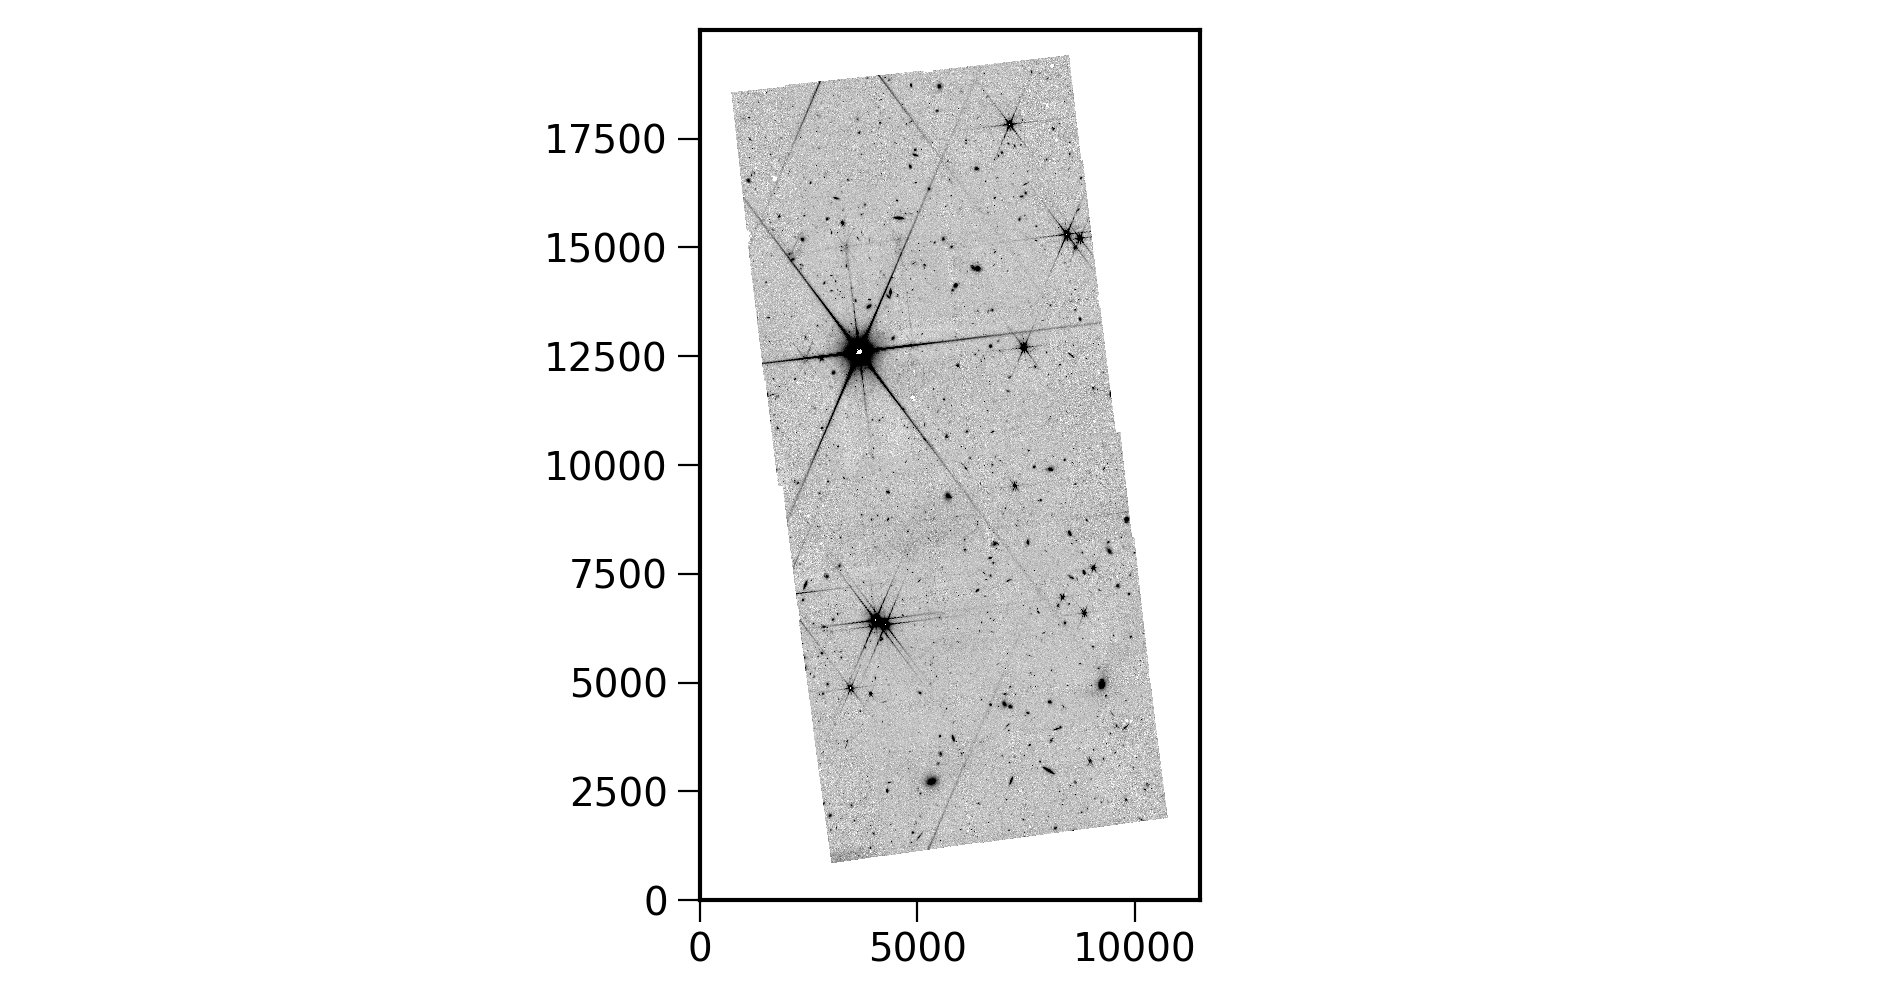

In [12]:
#data = image_data_dict[filters[-1]]
data = image_data_dict['f200w']

fig = plt.figure(figsize=(9.5, 5))
ax = fig.add_subplot(1, 1, 1)  # , projection=imwcs) # , sharex=True, sharey=True
data = np.where(data, data, np.nan) # Set data=nan where data=0
norm = simple_norm(data, 'sqrt', min_percent=1, max_percent=99)
plt.imshow(data, origin='lower', norm=norm, interpolation='none', cmap='Greys')

In [ ]:
# Show all images
if 0:
    nrows = 2
    ncolumns = int(np.ceil(len(filters) / nrows))
    fig, ax = plt.subplots(nrows, ncolumns, figsize=(9.5,5), sharex=True, sharey=True)

    norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.5)
    for i, filt in enumerate(filters):
        iy = i // ncolumns
        ix = i %  ncolumns
        hdu = fits.open(image_files_list[i])
        data = hdu[idata].data
        data = np.where(data, data, np.nan)  # ignore blank areas when scaling
        norm = simple_norm(data, 'sqrt', min_percent=0.1, max_percent=99.9)
        ax[iy,ix].imshow(data, origin='lower', interpolation='none', norm=norm, cmap='Greys')
        ax[iy,ix].set_title(filt)

# Sample a region of the image and make a color stamp

## A few different ways to assign colors to filters (or vice versa)

# Manual colors

In [67]:
out_ext = '20mas'
filter_colors = {}     # R, G, B
filter_colors['f070w'] = 0, 0, 1
filter_colors['f115w'] = 0, 1, 1
filter_colors['f200w'] = 0, 1, 0
#filter_colors['f212n']
filter_colors['f277w'] = 1, 0.5, 0
filter_colors['f356w'] = 1, 0.25, 0
#filter_colors['f410m'] = 0.5, 0, 0
filter_colors['f444w'] = 1, 0, 0
filters = filter_colors.keys()
filters

dict_keys(['f070w', 'f115w', 'f200w', 'f277w', 'f356w', 'f444w'])

In [72]:
out_ext = '20mas'
filter_colors = {}     # R, G, B
filter_colors['f070w'] = 0, 0, 1
filter_colors['f115w'] = 0, 1, 1
filter_colors['f200w'] = 0, 1, 0
#filter_colors['f212n']
filter_colors['f277w'] = 1, 0, 0
filter_colors['f356w'] = 1, 0, 0
#filter_colors['f410m'] = 0.5, 0, 0
filter_colors['f444w'] = 1, 0, 0
filters = filter_colors.keys()
filters

dict_keys(['f070w', 'f115w', 'f200w', 'f277w', 'f356w', 'f444w'])

In [ ]:
out_ext = 'sw3_20mas'

# Short Wavelength 3 blue
filter_colors = {}     # R, G, B
filter_colors['f070w'] = 0, 0, 1
filter_colors['f115w'] = 0, 1, 0
filter_colors['f200w'] = 1, 0, 0
filters = filter_colors.keys()

In [ ]:
# Long Wavelength only
out_ext = 'lw3'
filter_colors = {}     # R, G, B
filter_colors['f277w'] = 0, 0, 1
filter_colors['f356w'] = 0, 1, 0
filter_colors['f444w'] = 1, 0, 0
filters = filter_colors.keys()

# Rainbow automatic colors

In [59]:
#filters = 'f070w f115w f150w f200w'.split(); out_ext = 'sw'
#filters = 'f277w f356w f410m f444w'.split(); out_ext = 'lw'
filters = 'f070w f115w f200w f277w f356w f444w'.split(); out_ext = 'wide_20mas'

In [60]:
# I like this method to set colors for many filters
# note as implemented it does require boosting saturation after the fact

#out_ext = 'rainbow'

cmap = matplotlib.cm.get_cmap("rainbow")

filter_colors = {}
for i, filt in enumerate(filters):
    #x_min = 0.0  # bluest filter will be purple
    x_min = 0.1  # bluest filter will be blue
    x = i / (len(filters) - 1) * (1 - x_min) + x_min
    r_lum, g_lum, b_lum, alpha = cmap(x)
    rgb_lum = np.array([r_lum, g_lum, b_lum])
    filter_colors[filt] = rgb_lum
    print(filt, ' %4.2f' % r_lum, ' %4.2f' % g_lum, ' %4.2f' % b_lum)

f070w  0.30  0.30  0.99
f115w  0.06  0.77  0.91
f200w  0.42  0.99  0.75
f277w  0.78  0.91  0.54
f356w  1.00  0.54  0.28
f444w  1.00  0.00  0.00


# Define colors another way B, G, R

In [ ]:
def x_rgb(x):
    # -0.25 = purple
    # 0 = blue, 0.5 = green, 1 = red
    xp = -0.25, 0, 0.5, 1
    b_lum = np.interp(x, xp, [1,   1, 0, 0])
    g_lum = np.interp(x, xp, [0,   0, 1, 0])
    r_lum = np.interp(x, xp, [0.5, 0, 0, 1])
    return r_lum, g_lum, b_lum

len(filters)
x0 = 0
#x0 = -0.25
dx = 1 / (len(filters) - 1)
for x in np.arange(x0,1.01,dx):
    print(x, x_rgb(x))

# After assigning colors to filters

## Filter color sum

In [73]:
filters = filter_colors.keys()
print(filters)

for filt in filters:
    filter_colors[filt] = np.array(filter_colors[filt])
    
rgb_lum_sum = np.zeros(3)
for i, filt in enumerate(filters):
    rgb_lum_sum += np.array(filter_colors[filt])
    
rgb_lum_sum

dict_keys(['f070w', 'f115w', 'f200w', 'f277w', 'f356w', 'f444w'])


array([3., 2., 2.])

## Set parameters and iterate until it looks good

In [74]:
sample_size = 1000

dx = dy = 0  # don't use offset
xc, yc = 6300, 14500  # center of sample

noiselum   = 0.15  # brightness of "the noise"
satpercent = 0.01  # percentage of pixels allowed to saturate (e.g., to white)
unsatpercent = 1 - 0.01 * satpercent

noisesig = 1  # set e.g., 1-sigma noise to noiselum 
correctbias = True  # yes because need to dip below 0 by noisefloorsig-sigma
noisefloorsig = 2  #  set black to e.g., 2-sigma below; previously noisesigbias

color_saturation = 3

#out_ext = 'sw3_20mas_bright'

In [79]:
sample_size = 1000

dx = dy = 0  # don't use offset
xc, yc = 6300, 14500  # center of sample

noiselum   = 0.08  # brightness of "the noise"
satpercent = 0.003  # percentage of pixels allowed to saturate (e.g., to white)
unsatpercent = 1 - 0.01 * satpercent

noisesig = 1  # set e.g., 1-sigma noise to noiselum 
correctbias = True  # yes because need to dip below 0 by noisefloorsig-sigma
noisefloorsig = 1.5  #  set black to e.g., 2-sigma below; previously noisesigbias

color_saturation = 1.2

# Scale images and make color image stamp

In [80]:
scaled_images = {}
levels_all = {}
for filt in filters:
    data = image_data_dict[filt]
    #data = background_subtracted_dict[filt]
    print(filt, data.shape)
    my_stamp_extent = stamp_extent(data, sample_size, dx, dy, xc, yc)
    stamp = image_stamp(data, my_stamp_extent)
    levels = determine_scaling(stamp.ravel(), unsatpercent, noisesig, correctbias, noisefloorsig)
    scaled = imscale2(stamp, levels, noiselum)
    levels_all[filt] = levels
    scaled_images[filt] = scaled
    
rgb_total = 0
for filt in filters:
    rgb = r, g, b = filter_colors[filt][:, np.newaxis, np.newaxis] * scaled_images[filt]
    #imrgb = np.array([r, g, b]).transpose((1,2,0)).astype(np.uint8)    
    rgb_total = rgb_total + rgb
    
r, g, b = rgb_average = rgb_total / rgb_lum_sum[:, np.newaxis, np.newaxis]

imrgb = np.array([r, g, b]).transpose((1,2,0)).astype(np.uint8)

if 0:
    fig, ax = plt.subplots(1, 1, figsize=(9.5, 6))
    plt.imshow(imrgb, origin='lower', extent=my_stamp_extent) # (xlo,xhi,ylo,yhi))
else:
    im = Image.fromarray(imrgb, 'RGB')
    im = im.transpose(method=Image.Transpose.FLIP_TOP_BOTTOM)
    if color_saturation > 1:
        ImageEnhance.Color(im).enhance(color_saturation).show()
    else:
        im.show()

f070w (20000, 11500)
-0.00460606 +/- 0.0461031
f115w (20000, 11500)
-0.0047366 +/- 0.0311455
f200w (20000, 11500)
-0.000131998 +/- 0.0123866
f277w (20000, 11500)
0.00332691 +/- 0.0332612
f356w (20000, 11500)
0.00281111 +/- 0.0219456
f444w (20000, 11500)
0.00165501 +/- 0.0493488


# (Optional) Show filter image stamps in each color they're assigned

<IPython.core.display.Javascript object>


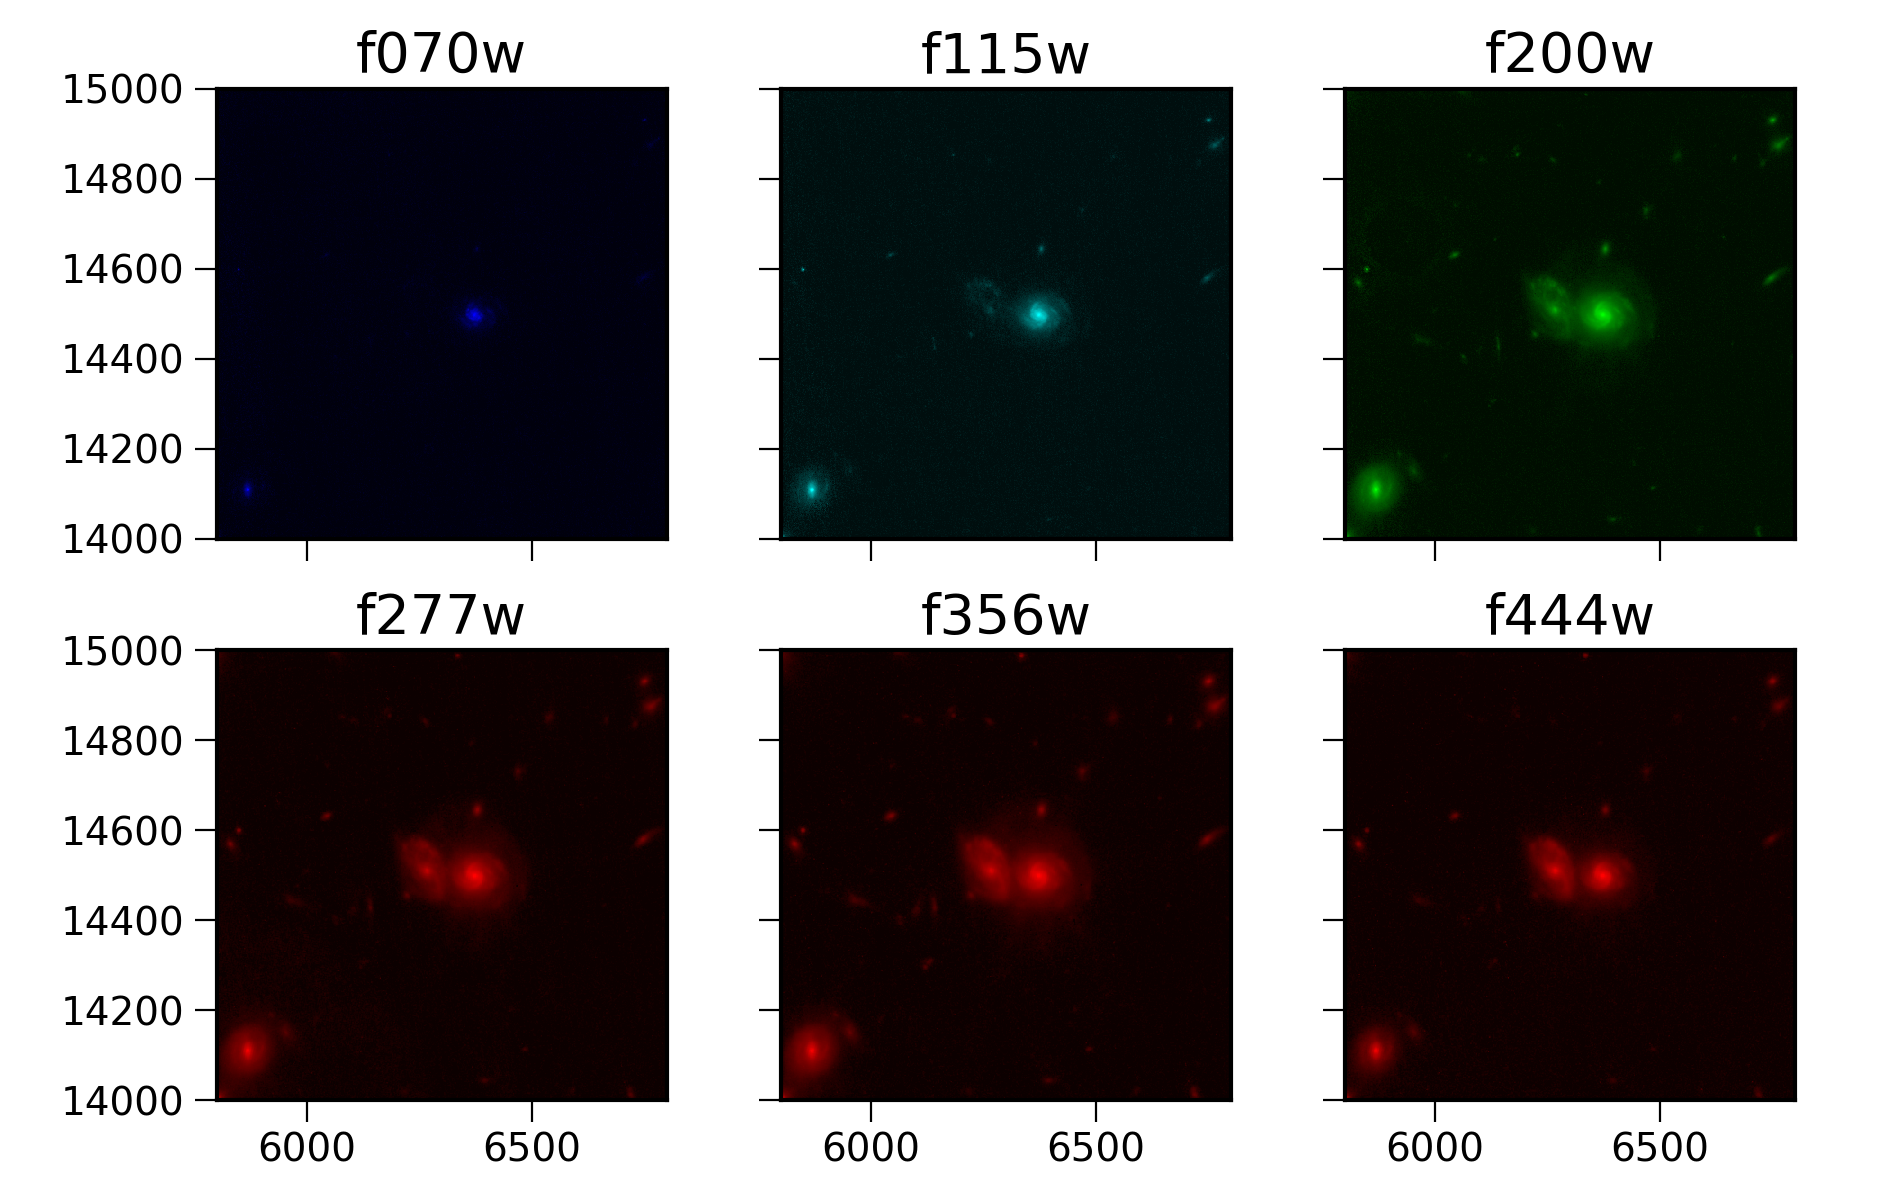

In [81]:
nrows = 2
ncolumns = int(np.ceil(len(filters) / nrows))

fig, ax = plt.subplots(nrows, ncolumns, figsize=(9.5,6), sharex=True, sharey=True)

for i, filt in enumerate(filters):
    r, g, b = filter_colors[filt][:, np.newaxis, np.newaxis] * scaled_images[filt]
    imrgb = np.array([r, g, b]).transpose((1,2,0)).astype(np.uint8)
    ix = i % ncolumns
    iy = int(i / ncolumns)
    if nrows == 1:
        ax[ix].imshow(imrgb, origin='lower', interpolation='none', cmap='Greys_r', extent=my_stamp_extent)
        ax[ix].set_title(filt)
    else:
        ax[iy,ix].imshow(imrgb, origin='lower', interpolation='none', cmap='Greys_r', extent=my_stamp_extent)
        ax[iy,ix].set_title(filt)

## Once you're happy with the color image stamp,
# Create and save the full color image

In [82]:
#out_ext = 'all'
out_ext

'20mas'

In [83]:
scaled_images = {}
for filt in filters:
    data = image_data_dict[filt]
    #data = background_subtracted_dict[filt]
    levels = levels_all[filt]
    scaled = imscale2(data, levels, noiselum)
    scaled_images[filt] = scaled
    
rgb_total = 0
for filt in filters:
    rgb = r, g, b = filter_colors[filt][:, np.newaxis, np.newaxis] * scaled_images[filt]
    rgb_total = rgb_total + rgb
    
r, g, b = rgb_average = rgb_total / rgb_lum_sum[:, np.newaxis, np.newaxis]

imrgb = np.array([r, g, b]).transpose((1,2,0)).astype(np.uint8)

if 0:  # don't plot, just save it below
    fig, ax = plt.subplots(1, 1, figsize=(9.5, 6))
    plt.imshow(imrgb, origin='lower') # (xlo,xhi,ylo,yhi))

In [84]:
im = Image.fromarray(imrgb, 'RGB')
im = im.transpose(method=Image.Transpose.FLIP_TOP_BOTTOM)

if color_saturation > 1:
    im = ImageEnhance.Color(im).enhance(color_saturation)

In [85]:
outfile = field + '_color.png'
if out_ext:
    outfile = outfile.replace('.png', '_'+out_ext+'.png')

outfile

'nep-2mass_color_20mas.png'

In [86]:
if os.path.exists(outfile):
    print(outfile, 'EXISTS')
else:
    print('SAVING', outfile)
    #matplotlib.image.imsave(outfile, imrgb)
    im.save(outfile)

SAVING nep-2mass_color_20mas.png


# Add creation info to image meta data

In [ ]:
from PIL.PngImagePlugin import PngInfo



In [ ]:
Add creation info to image meta data

https://stackoverflow.com/questions/58399070/how-do-i-save-custom-information-to-a-png-image-file-in-python

from PIL import Image
from PIL.PngImagePlugin import PngInfo

targetImage = Image.open("pathToImage.png")

metadata = PngInfo()
metadata.add_text("MyNewString", "A string")
metadata.add_text("MyNewInt", str(1234))

targetImage.save("NewPath.png", pnginfo=metadata)
targetImage = Image.open("NewPath.png")

print(targetImage.text)

>>> {'MyNewString': 'A string', 'MyNewInt': '1234'}

# OPTIONAL

# Increase color saturation

In [ ]:
# increase color saturation

def satK2m(K):
    # Luminance vector
    # All pretty similar; yellow galaxy glow extended a bit more in NTSC
    #rw, gw, bw = 0.299,  0.587,  0.114  # NTSC (also used by PIL in "convert")
    #rw, gw, bw = 0.3086, 0.6094, 0.0820  # linear
    rw, gw, bw = 0.212671, 0.715160, 0.072169  # D65: red boosted, blue muted a bit, I like it

    m00 = rw * (1-K) + K
    m01 = gw * (1-K)
    m02 = bw * (1-K)
    
    m10 = rw * (1-K)
    m11 = gw * (1-K) + K
    m12 = bw * (1-K)
    
    m20 = rw * (1-K)
    m21 = gw * (1-K)
    m22 = bw * (1-K) + K
    
    m = np.array([[m00, m01, m02], [m10, m11, m12], [m20, m21, m22]])
    return m

# also see PIL's ImageEnhance.Contrast
def adjust_color_saturation(RGB, K):
    """Adjust the color saturation of an image.  K > 1 boosts it."""
    m = satK2m(K)
    #three, nx, ny = RGB.shape
    ny, nx, three = RGB.shape
    print(three, nx, ny)
    #RGB.shape = three, nx*ny
    RGB.shape = nx*ny, three
    #RGB = np.dot(m, RGB)
    RGB = np.dot(RGB, m)
    #RGB.shape = three, nx, ny
    RGB.shape = ny, nx, three
    return RGB

In [ ]:
# Couldn't quite get this to work...
imrgb2 = adjust_color_saturation(imrgb/255, 2)
fig, ax = plt.subplots(1, 1, figsize=(9.5, 6))
plt.imshow(imrgb2/2, origin='lower', extent=my_stamp_extent) # (xlo,xhi,ylo,yhi))